<br/><br/>
<a id='Header' style="font-size:40px; color:#1D2951; text-decoration:none; text-align:center;">
    <center><b>Bike Sharing Demand</b></center>
</a>

<br/><br/>

<a id='Header' style="font-size:30px; color:#1D2951; text-decoration:none">
    <b> Table of Contents </b>
</a> 
<ul>
<li><a href="#intro" style="font-size:15px; color:#1D2951">Introduction</a></li>
<li><a href="#libraries" style="font-size:15px; color:#1D2951">Importing Libraries</a></li>
<li><a href="#overview" style="font-size:15px; color:#1D2951">Dataset Overview</a></li>
<li><a href="#init" style="font-size:15px; color:#1D2951">Initial Model</a></li>
<li><a href="#features" style="font-size:15px; color:#1D2951">Adding features</a></li>
<li><a href="#hypo" style="font-size:15px; color:#1D2951">Hyperparameter and tuning</a></li>
<li><a href="#end" style="font-size:15px; color:#1D2951">Conclusion</a></li>

</ul>

<hr>

<a id='intro' style="font-size:30px; color:#1D2951; text-decoration:none"><b>Introduction</b></a>

<p style="font-size:17px"> Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.
    
The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C. 
</p>

</p>

<a id='libraries' style="font-size:30px; color:#1D2951; text-decoration:none"><b>Importing Libraries</b></a>

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from autogluon.tabular import TabularPredictor

<a id='overview' style="font-size:30px; color:#1D2951; text-decoration:none"><b>Dataset Overview</b></a>

In [2]:
bike_train = pd.read_csv("train.csv")
bike_test  = pd.read_csv("test.csv")
bike_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
print(bike_train.info())
print("-" * 40)
print(bike_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6

###### As we see the data is clean there are no nulls values, so let's check the correlations between columns and apply the model directly without changing or adding any features to the data

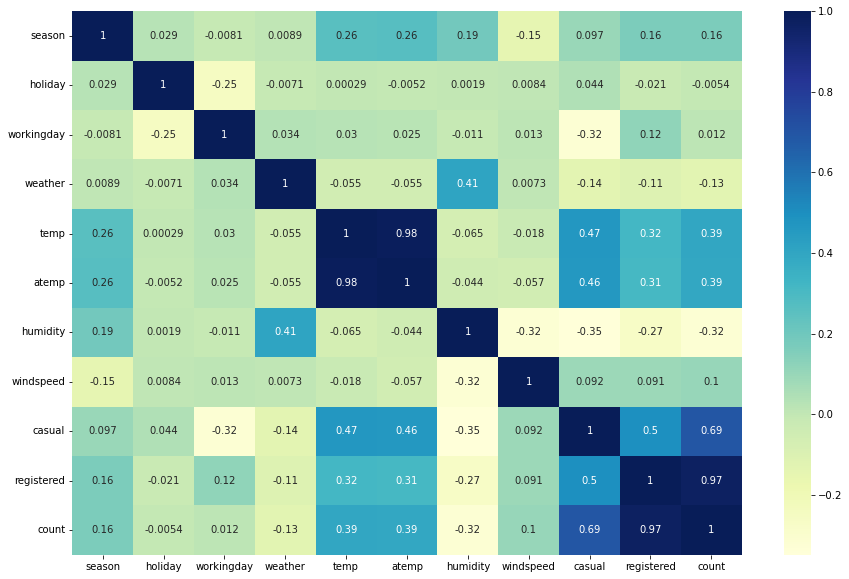

In [4]:
corrmat = bike_train.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,10))

g = sns.heatmap(bike_train[top_corr_features].corr(), annot= True, cmap = "YlGnBu")

In [5]:
bike_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


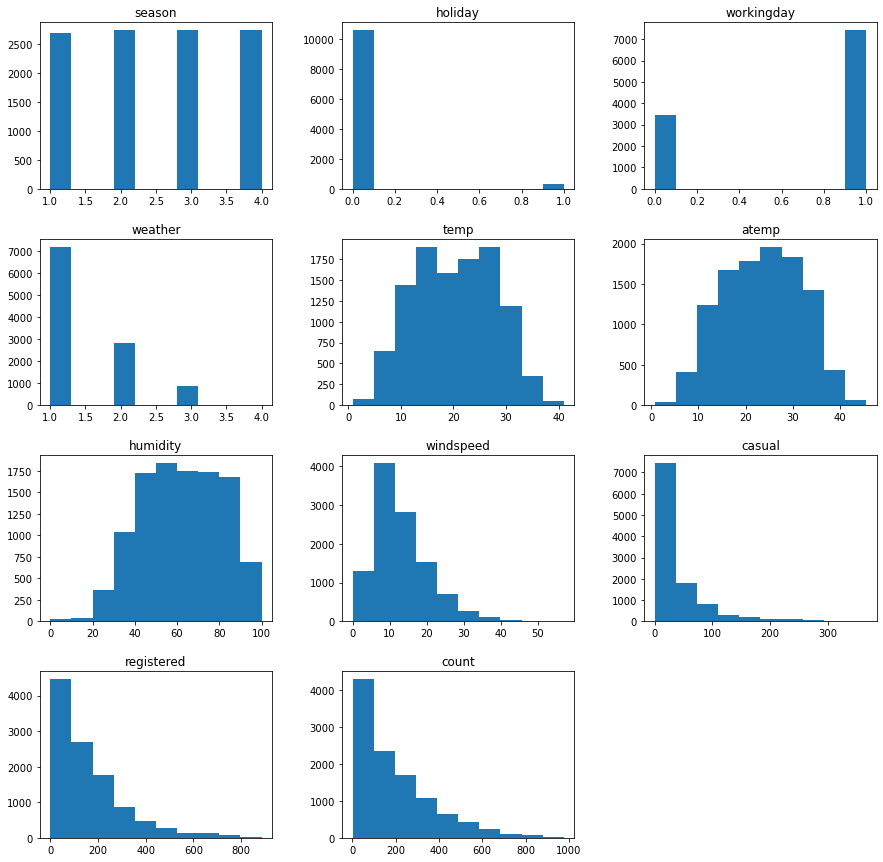

In [6]:
bike_train.hist(figsize=(15,15), grid=False);

<a id='init' style="font-size:30px; color:#1D2951; text-decoration:none"><b>Initial Model</b></a>

###### But before training the data we should drop columns 'Casual' and 'Registered' because they are missed from test dataset

In [7]:
bike_train =bike_train.drop(['casual','registered'], axis = 1)

In [8]:
predictor = TabularPredictor(label="count", problem_type="regression", eval_metric="r2").fit(
    train_data=bike_train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220726_143349\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220726_143349\"
AutoGluon Version:  0.5.0
Python Version:     3.7.3
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11090.58 MB
	Train Data (Original)  Memory Usage: 1.52 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 2 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identit

In [9]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.922126      25.438164  414.504613                0.000000           0.477051            3       True         16
1   NeuralNetFastAI_BAG_L2   0.918235      23.860596  400.203730                0.828243          48.226466            2       True         15
2   RandomForestMSE_BAG_L2   0.914117      23.819427  362.279108                0.787074          10.301845            2       True         12
3     ExtraTreesMSE_BAG_L2   0.912022      23.822847  355.499251                0.790493           3.521988            2       True         14
4          LightGBM_BAG_L2   0.908194      23.479376  359.955587                0.447022           7.978324            2       True         11
5          CatBoost_BAG_L2   0.906622      23.116855  413.840051                

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': 0.6857083919031295,
  'KNeighborsDist_BAG_L1': 0.7842961478992944,

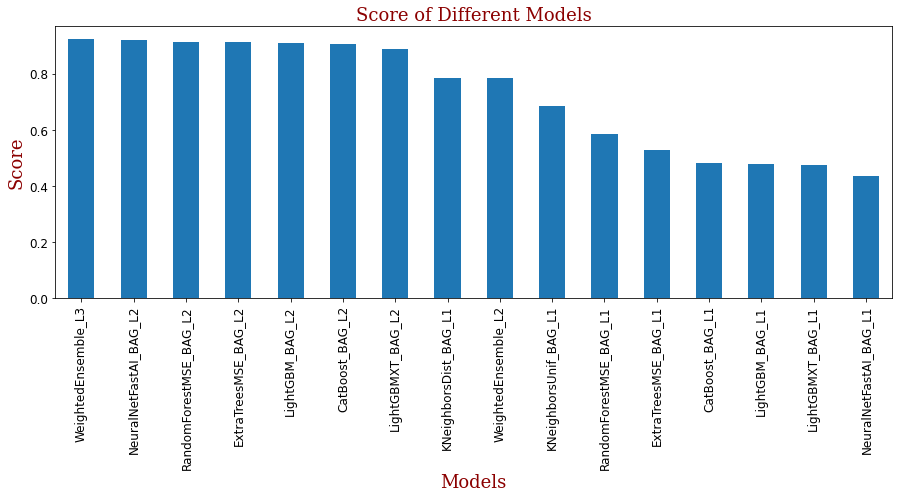

In [10]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

predictor.leaderboard(silent=True).plot(kind="bar",x="model",y="score_val",figsize=(15,5), legend = False,fontsize=12)

plt.title("Score of Different Models",fontdict=font)
plt.xlabel('Models', fontdict=font)
plt.ylabel('Score', fontdict=font);

In [60]:
# Predict the values in test data
count_predict_initial = round(predictor.predict(bike_test))

# replace any negative number to 0 because there isn't demand with negative!
count_predict_initial[count_predict_initial < 0] = 0
print("Number of negative values in the count column:", (count_predict_features < 0).sum())

Number of negative values in the count column: 0


In [54]:
# Saving the File to sumbit it in Kaggle
test = pd.read_csv('test.csv')
output = pd.DataFrame({'datetime': test.datetime, 'count': count_predict_initial})
output.to_csv('submission_initial.csv', index=False, date_format='%Y-%m-%dT%H:%M')

###### The score is [from Kaggle]: 1.79498!

<a id='features' style="font-size:30px; color:#1D2951; text-decoration:none"><b>Adding features</b></a>

In [14]:
for col in [bike_train,bike_test]:
    col['datetime'] = col['datetime'].astype('datetime64[ns]')
    col['year'] = col['datetime'].dt.year
    col['month'] = col['datetime'].dt.month
    col['day'] = col['datetime'].dt.day
    col['hour'] = col['datetime'].dt.hour
    
    
    # Change the type of season and weather to Categorical type
    col["season"] = col['season'].astype('category')
    col["weather"] = col['weather'].astype('category')

In [15]:
bike_train =bike_train.drop(['datetime'], axis = 1)
bike_test = bike_test.drop(['datetime'], axis = 1)

In [16]:
print(bike_train.info())
print("-" * 40)
print(bike_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  int64   
 2   workingday  10886 non-null  int64   
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   count       10886 non-null  int64   
 9   year        10886 non-null  int64   
 10  month       10886 non-null  int64   
 11  day         10886 non-null  int64   
 12  hour        10886 non-null  int64   
dtypes: category(2), float64(3), int64(8)
memory usage: 957.3 KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
-

In [17]:
bike_train.head(1)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0


In [18]:
scaler = MinMaxScaler()
for col in [bike_train, bike_test]:
    col.loc[:,col.columns != "count"] = scaler.fit_transform(col.loc[:,col.columns != "count"])

In [19]:
predictor = TabularPredictor(label="count", problem_type="regression", eval_metric="r2").fit(
    train_data=bike_train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20220726_144522\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20220726_144522\"
AutoGluon Version:  0.5.0
Python Version:     3.7.3
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10567.48 MB
	Train Data (Original)  Memory Usage: 1.05 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 3 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	Stage 3 Generators:
		Fitting Identi

In [20]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3   0.961097      39.498703  460.781258                0.001000           0.663036            3       True         18
1      WeightedEnsemble_L2   0.960772      36.212559  314.292367                0.001000           0.640244            2       True          9
2     ExtraTreesMSE_BAG_L2   0.960305      37.894846  358.840008                0.798110           3.499241            2       True         14
3          CatBoost_BAG_L2   0.960236      37.168740  371.881679                0.072004          16.540911            2       True         13
4   NeuralNetFastAI_BAG_L2   0.959712      37.891026  410.336327                0.794291          54.995559            2       True         15
5          LightGBM_BAG_L2   0.959486      37.272747  364.872524                

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L3': 'WeightedEnsemb

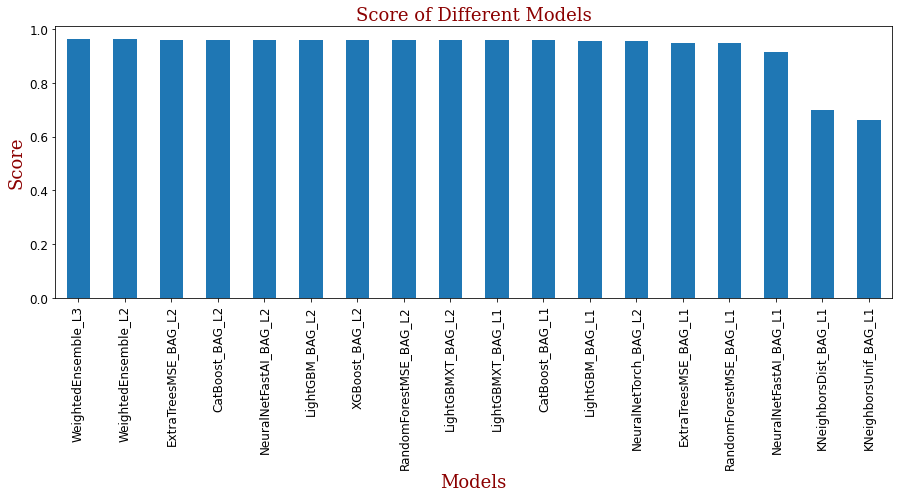

In [21]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

predictor.leaderboard(silent=True).plot(kind="bar",x="model",y="score_val",figsize=(15,5), legend = False,fontsize=12)

plt.title("Score of Different Models",fontdict=font)
plt.xlabel('Models', fontdict=font)
plt.ylabel('Score', fontdict=font);

In [58]:
Predict the values in test data
count_predict_features = round(predictor.predict(bike_test))

# replace any negative number to 0 because there isn't demand with negative!
count_predict_features[count_predict_features < 0] = 0
print("Number of negative values in the count column:", (count_predict_features < 0).sum())

Number of negative values in the count column: 0


In [56]:
# Saving the File to sumbit it in Kaggle
test = pd.read_csv('test.csv')
output = pd.DataFrame({'datetime': test.datetime, 'count': count_predict_features})
output.to_csv('submission_features.csv', index=False, date_format='%Y-%m-%dT%H:%M')

###### The score is [from Kaggle]: 0.46463

<a id='hypo' style="font-size:30px; color:#1D2951; text-decoration:none"><b>Hyperparameter and tuning</b></a>

In [32]:
import autogluon.core as ag

nn_options = {
    'num_epochs': 10,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(1e-4, 1e-2, default=5e-4, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'softrelu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

gbm_options = { 
    'num_boost_round': 100,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
}

hyperparameters = { 
                   'GBM': gbm_options,
                   'NN_TORCH': nn_options,  # NOTE: comment this line out if you get errors on Mac OSX
                  }  # When these keys are missing from hyperparameters dict, no models of that type are trained

time_limit = 900
num_trials = 5  
search_strategy = 'auto'
presets="best_quality"

hyperparameter_tune_kwargs = {
    'num_trials': num_trials,
    'scheduler' : 'local',
    'searcher': search_strategy,
}

In [33]:
predictor = TabularPredictor(label="count", eval_metric="r2").fit(
    train_data=bike_train, time_limit=time_limit,
     hyperparameters=hyperparameters ,hyperparameter_tune_kwargs=hyperparameter_tune_kwargs, presets=presets
)

No path specified. Models will be saved in: "AutogluonModels/ag-20220726_152221\"
Presets specified: ['best_quality']
Beginning AutoGluon training ... Time limit = 900s
AutoGluon will save models to "AutogluonModels/ag-20220726_152221\"
AutoGluon Version:  0.5.0
Python Version:     3.7.3
Operating System:   Windows
Train Data Rows:    10886
Train Data Columns: 12
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9793.64 MB
	Train Data (Original)  Memory Usage: 1

  0%|          | 0/5 [00:00<?, ?it/s]

Fitted model: LightGBM_BAG_L1\T1 ...
	0.9419	 = Validation score   (r2)
	0.32s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T2 ...
	0.9469	 = Validation score   (r2)
	0.31s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T3 ...
	0.9457	 = Validation score   (r2)
	0.4s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T4 ...
	0.5324	 = Validation score   (r2)
	0.38s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L1\T5 ...
	0.9335	 = Validation score   (r2)
	0.47s	 = Training   runtime
	0.01s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L1 ... Tuning model for up to 33.74s of the 897.43s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L1\T1 ...
	0.6451	 = Validation score   (r2)
	7.86s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: NeuralNetTorch_BAG_L1\T2 ...
	0.9091	 = Validation score   (r2)
	18.46s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM_BAG_L1\T1 ... Training model for up to 570.55s of the 870.66s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	0.9391	 = Validation score   (r2)
	7.64s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: LightGBM_BAG_L1\T2 ... Training model for up to 555.92s of the 856.02s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	0.9432	 = Validation score   (r2)
	6.88s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: LightGBM_BAG_L1\T3 ... Training model for up to 541.39s of the 841.5s of remaining time.
	Fitting 7 child

  0%|          | 0/5 [00:00<?, ?it/s]

Fitted model: LightGBM_BAG_L2\T1 ...
	0.9423	 = Validation score   (r2)
	0.59s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T2 ...
	0.9427	 = Validation score   (r2)
	0.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T3 ...
	0.9421	 = Validation score   (r2)
	0.66s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T4 ...
	0.6697	 = Validation score   (r2)
	0.54s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: LightGBM_BAG_L2\T5 ...
	0.941	 = Validation score   (r2)
	0.55s	 = Training   runtime
	0.01s	 = Validation runtime
Hyperparameter tuning model: NeuralNetTorch_BAG_L2 ... Tuning model for up to 19.63s of the 345.38s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetTorch_BAG_L2\T1 ...
	0.9355	 = Validation score   (r2)
	8.15s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM_BAG_L2\T1 ... Training model for up to 336.95s of the 336.94s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	0.9494	 = Validation score   (r2)
	6.82s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: LightGBM_BAG_L2\T2 ... Training model for up to 320.05s of the 320.03s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	0.9495	 = Validation score   (r2)
	9.95s	 = Training   runtime
	0.19s	 = Validation runtime
Fitting model: LightGBM_BAG_L2\T3 ... Training model for up to 300.21s of the 300.2s of remaining time.
	Fitting 7 child models (S1F2 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	0.9498	 = Validation score   (r2)
	10.44s	 = Training   runtime
	0

In [ ]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 18,
        }

predictor.leaderboard(silent=True).plot(kind="bar",x="model",y="score_val",figsize=(15,5), legend = False,fontsize=12)

plt.title("Score of Different Models",fontdict=font)
plt.xlabel('Models', fontdict=font)
plt.ylabel('Score', fontdict=font);

In [59]:
# Predict the values in test data
count_predict_hypo = round(predictor.predict(bike_test))

# replace any negative number to 0 because there isn't demand with negative!
count_predict_hypo[count_predict_hypo < 0] = 0
print("Number of negative values in the count column:", (count_predict_features < 0).sum())

Number of negative values in the count column: 0


In [55]:
# Saving the File to sumbit it in Kaggle
test = pd.read_csv('test.csv')
output = pd.DataFrame({'datetime': test.datetime, 'count': count_predict_hypo})
output.to_csv('submission_hypo.csv', index=False, date_format='%Y-%m-%dT%H:%M')

###### The score is [from Kaggle]: 0.46350

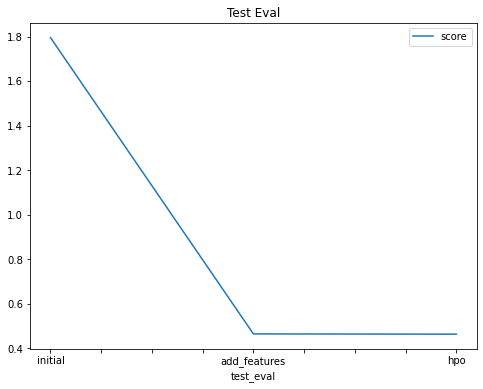

In [41]:
# Take the 3 kaggle scores and creating a line plot to show improvement

fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.79498, 0.46463, 0.46350]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

plt.title("Test Eval");

<a id='end' style="font-size:30px; color:#1D2951; text-decoration:none"><b>Conclusion</b></a>

In [3]:
# The conclusion of each trained models and it's score
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "score": [1.79498, 0.46463, 0.46350]
})

,model,score
0,initial,1.79498
1,add_features,0.46463
2,hpo,0.46350
